
=== Database Connection: Config Values ===
{'host': 'localhost', 'database': 'cs_usgs', 'user': 'postgres', 'password': 'Codio590'}

=== Database Connection: Test Query ===
Connecting to our PostgreSQL database...
('cs_usgs',)

=== Database Connection: Connection Target (no password) ===
Connection target (no password): host=localhost, db=cs_usgs, user=postgres

=== Pulling Data For Dashboard ===

=== Running Query ===
SELECT date_trunc('day', e.time_utc) AS day,
       COUNT(*) AS event_count
FROM public.earthquake_event e
GROUP BY day
ORDER BY day;
Rows returned: 31

=== Running Query ===
SELECT
  e.event_id,
  e.magnitude,
  e.time_utc,
  e.place,
  l.latitude,
  l.longitude,
  l.depth_km
FROM public.earthquake_event e
JOIN public.event_location l ON l.location_id = e.location_id
WHERE e.magnitude IS NOT NULL
  AND l.latitude IS NOT NULL
  AND l.longitude IS NOT NULL;
Rows returned: 6701

=== Preview: Time Series Data ===


,day,event_count
0,2025-03-16,92
1,2025-03-17,271
2,2025-03-18,264
3,2025-03-19,223
4,2025-03-20,380



=== Preview: Map Data ===


,event_id,magnitude,time_utc,place,latitude,longitude,depth_km
0,ak0253gekh37,2.80,2025-03-16 22:27:57.363,"32 km S of Whittier, Alaska",60.480400,-148.727900,8.900
1,us7000pmct,2.50,2025-03-21 06:40:56.758,"77 km SSE of Adak, Alaska",51.211800,-176.293400,22.600
2,ak02543gh60i,1.90,2025-03-30 16:20:26.068,"74 km NW of Yakutat, Alaska",59.966200,-140.760500,0.000
3,us7000pn3b,4.90,2025-03-18 14:14:38.683,"130 km ESE of Kirakira, Solomon Islands",-10.796100,163.063000,38.725
4,nc75153482,1.73,2025-03-22 22:44:52.790,"20 km NW of Alder Springs, CA",39.746167,-122.924167,-1.440



=== Quick Chart: Earthquakes per Day ===


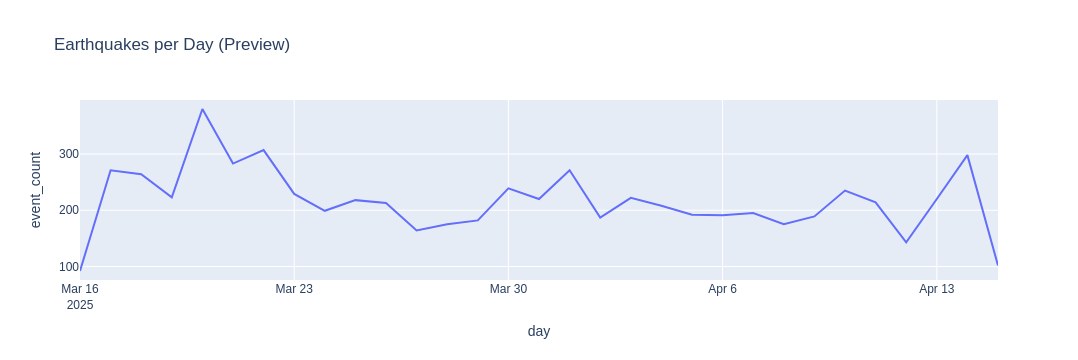


=== Quick Chart: Locations (lon/lat) ===


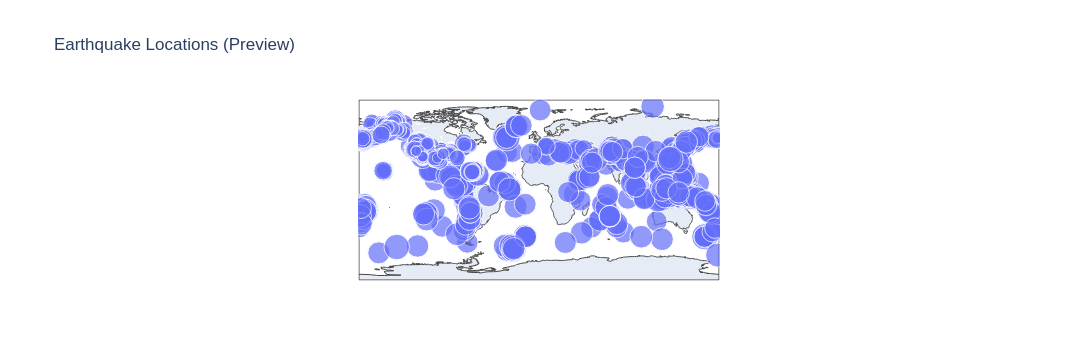


=== Dashboard Settings ===
Dashboard date range: 2025-03-16 00:00:00 to 2025-04-15 00:00:00
Magnitude range: 0.95 to 7.7


In [8]:
# ------------------------------
# Notebook Settings (suppress non-fatal warnings)
# ------------------------------
import warnings

# Hide the Pandas "SQLAlchemy recommended" warning (your code still works)
warnings.filterwarnings(
    "ignore",
    message="pandas only supports SQLAlchemy connectable*",
    category=UserWarning
)

# Hide JupyterDash deprecation warning (we're removing JupyterDash anyway)
warnings.filterwarnings(
    "ignore",
    message="JupyterDash is deprecated*",
    category=UserWarning
)

# ------------------------------
# Database Connection (DO NOT CHANGE)
# ------------------------------

import psycopg2
from configparser import ConfigParser

def config(filename, section):
    cp = ConfigParser()
    cp.read(filename)

    block = {}

    if cp.has_section(section):
        items = cp.items(section)
        for item in items:
            block[item[0]] = item[1]
    else:
        raise Exception(f"Section {section} was not found in the {filename} file!")

    return block


def displayConfig(filename, section):
    confData = config(filename, section)
    print(confData)


def dbConnect(filename, section):
    confData = config(filename, section)
    conn = None

    try:
        conn = psycopg2.connect(
            dbname = confData["database"],
            user = confData["user"],
            password = confData["password"],
            host = confData["host"]
        )
        return conn
    except(Exception, psycopg2.DatabaseError) as error:
        print(error)
        return None


def dbTest(filename, section):
    print('Connecting to our PostgreSQL database...')
    conn = dbConnect(filename, section)

    try:
        cursor = conn.cursor()
        cursor.execute('SELECT current_database()')
        print(cursor.fetchone())
        cursor.close()
    except(Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
# ------------------------------
# Connection Test
# ------------------------------

CONF_FILE = "database.conf"
CONF_SECTION = "postgresql"

print("\n=== Database Connection: Config Values ===")
displayConfig(CONF_FILE, CONF_SECTION)

print("\n=== Database Connection: Test Query ===")
dbTest(CONF_FILE, CONF_SECTION)

conf = config(CONF_FILE, CONF_SECTION)
print("\n=== Database Connection: Connection Target (no password) ===")
print(f"Connection target (no password): host={conf['host']}, db={conf['database']}, user={conf['user']}")

# ------------------------------
# Queries (PostgreSQL -> Pandas DataFrames)
# ------------------------------

import pandas as pd

def query_to_df(sql: str, filename: str = CONF_FILE, section: str = CONF_SECTION) -> pd.DataFrame:
    print("\n=== Running Query ===")
    print(sql.strip())

    conn = dbConnect(filename, section)
    if conn is None:
        raise RuntimeError("Database connection failed. Check database.conf and PostgreSQL status.")

    try:
        df = pd.read_sql_query(sql, conn)
        print(f"Rows returned: {len(df)}")
        return df
    finally:
        conn.close()


SQL_TIME_SERIES = """
SELECT date_trunc('day', e.time_utc) AS day,
       COUNT(*) AS event_count
FROM public.earthquake_event e
GROUP BY day
ORDER BY day;
"""

SQL_MAP_POINTS = """
SELECT
  e.event_id,
  e.magnitude,
  e.time_utc,
  e.place,
  l.latitude,
  l.longitude,
  l.depth_km
FROM public.earthquake_event e
JOIN public.event_location l ON l.location_id = e.location_id
WHERE e.magnitude IS NOT NULL
  AND l.latitude IS NOT NULL
  AND l.longitude IS NOT NULL;
"""

print("\n=== Pulling Data For Dashboard ===")
df_time = query_to_df(SQL_TIME_SERIES)
df_map  = query_to_df(SQL_MAP_POINTS)

print("\n=== Preview: Time Series Data ===")
display(df_time.head())

print("\n=== Preview: Map Data ===")
display(df_map.head())

# ------------------------------
# Quick Visual Checks (Plotly only, avoids matplotlib/Numpy issue)
# ------------------------------

import plotly.express as px

print("\n=== Quick Chart: Earthquakes per Day ===")
fig_ts_preview = px.line(df_time, x="day", y="event_count", title="Earthquakes per Day (Preview)")
fig_ts_preview.show()

print("\n=== Quick Chart: Locations (lon/lat) ===")
fig_map_preview = px.scatter_geo(
    df_map,
    lat="latitude",
    lon="longitude",
    size="magnitude",
    hover_name="place",
    title="Earthquake Locations (Preview)"
)
fig_map_preview.show()

# ------------------------------
# Interactive Dashboard (Dash in Jupyter) - FIXED
# ------------------------------

from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import pandas as pd

df_map_local = df_map.copy()
df_map_local["day"] = pd.to_datetime(df_map_local["time_utc"]).dt.floor("D")

min_day = df_map_local["day"].min()
max_day = df_map_local["day"].max()

min_mag = float(df_map_local["magnitude"].min())
max_mag = float(df_map_local["magnitude"].max())

print("\n=== Dashboard Settings ===")
print(f"Dashboard date range: {min_day} to {max_day}")
print(f"Magnitude range: {min_mag} to {max_mag}")

app = Dash(__name__)

app.layout = html.Div([
    html.H2("USGS Earthquake Dashboard (PostgreSQL + Jupyter)"),

    html.Div([
        html.Div([
            html.Label("Minimum magnitude"),
            dcc.Slider(
                id="min-mag",
                min=min_mag,
                max=max_mag,
                step=0.1,
                value=max(2.5, min_mag),
                marks=None,
                tooltip={"placement": "bottom", "always_visible": True}
            ),
        ], style={"width": "48%", "display": "inline-block", "verticalAlign": "top"}),

        html.Div([
            html.Label("Date range (UTC)"),
            dcc.DatePickerRange(
                id="date-range",
                min_date_allowed=min_day.date(),
                max_date_allowed=max_day.date(),
                start_date=min_day.date(),
                end_date=max_day.date(),
                display_format="YYYY-MM-DD"
            ),
        ], style={"width": "48%", "display": "inline-block", "marginLeft": "4%"}),
    ], style={"marginBottom": "20px"}),

    dcc.Graph(id="time-series"),
    dcc.Graph(id="map-scatter"),
    html.Div(id="summary", style={"marginTop": "10px"})
])

@app.callback(
    Output("time-series", "figure"),
    Output("map-scatter", "figure"),
    Output("summary", "children"),
    Input("min-mag", "value"),
    Input("date-range", "start_date"),
    Input("date-range", "end_date"),
)
def update_views(min_mag_value, start_date, end_date):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    filtered = df_map_local[
        (df_map_local["magnitude"] >= float(min_mag_value)) &
        (df_map_local["day"] >= start_date) &
        (df_map_local["day"] <= end_date)
    ].copy()

    ts = filtered.groupby("day").size().reset_index(name="event_count")

    fig_ts = px.line(ts, x="day", y="event_count", title="Earthquakes per day (filtered)")
    fig_ts.update_layout(xaxis_title="Day (UTC)", yaxis_title="Event count")

    fig_map = px.scatter_geo(
        filtered,
        lat="latitude",
        lon="longitude",
        size="magnitude",
        hover_name="place",
        hover_data={"magnitude": True, "depth_km": True, "time_utc": True},
        title="Earthquake locations (size = magnitude)"
    )

    summary = f"Filtered events: {len(filtered)} from {start_date.date()} to {end_date.date()} at magnitude >= {min_mag_value}"
    return fig_ts, fig_map, summary


# Dash Jupyter mode (this is the key difference)
app.run(jupyter_mode="inline", debug=False)
